# analysis

## ToDo

- ~~Importing more than one json file~~
- ~~How to group by subjects models and movement~~
- ~~Model specific confusion rat~~
- How to manage or represent all this data
- ...

## data structure

Grouping
- subjects
- models
    - type overall
    - individual configuration
- movement
    - type overall
    - with(out) contact

## loading data
json file needs to be normalized

In [298]:
import numpy as np
import pandas as pd
import json, os
import matplotlib.pyplot as plt
import seaborn as sns

In [299]:
def parse_modelname(x='model(dmp)-dataset(return-bottle-hold)-npsi(90)-hold(1)'):
    x = x.split('-dataset(')
    typ = x[1].split(')',1)
    typ = typ[1]
    x = x[0].split('model(')
    x = x[1][:-1]
    return x + typ

In [300]:
path_to_json = '/users/hieu/git/turing_test_walking/data'

json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
first_file = json_files.pop()
with open(first_file,'r') as f:
    one = json.loads(f.read())
data = pd.json_normalize(one)

#workaround for concatenating unnormalized data
for file in json_files:
    with open(file,'r') as f:
        one = json.loads(f.read())
    load = pd.json_normalize(one)
    data = pd.concat([data,load])

In [301]:
data

,rt,stimulus,button_pressed,trial_type,trial_index,time_elapsed,internal_node_id,subject,view_history,key_press,test_part,test_stimulus.position,test_stimulus.left,test_stimulus.right,test_stimulus.att_check,sona
0,973.000,<p>Welcome!<br> Please choose your language to...,1,html-button-response,0,980,0.0-0.0,bt4quvsv7wdsku4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2206.000,NaN,NaN,instructions,1,3188,0.0-1.0-0.0,bt4quvsv7wdsku4,"[{""page_index"":0,""viewing_time"":515},{""page_in...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,785.000,<p>Bereit?</p>,0,html-button-response,2,3976,0.0-3.0,bt4quvsv7wdsku4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"<div style=""font-size:60px;"">+</div>",NaN,html-keyboard-response,3,5981,0.0-4.0,bt4quvsv7wdsku4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,training,4,9769,0.0-5.0,bt4quvsv7wdsku4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,1274.935,<p>Welche Sequenz haben Sie als natürlicher em...,1,html-button-response,42,245523,0.0-7.0-3.8,onzokuqujwnax3t,NaN,NaN,response,0.0,bvh/return-bottle-training2-lines.txt,bvh/vr_prediction_models/model(tmp)-dataset(re...,False,NaN
43,981.395,<p>Bereit?</p>,0,html-button-response,43,246508,0.0-7.0-0.9,onzokuqujwnax3t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,"<div style=""font-size:60px;"">+</div>",NaN,html-keyboard-response,44,248512,0.0-7.0-1.9,onzokuqujwnax3t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,turing-test,45,254185,0.0-7.0-2.9,onzokuqujwnax3t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  ## parsing

In [302]:
# filtering test parts and creating new index

df = data[data['test_part'] == 'response'].reset_index()

# this line below for filtering attention checks overall out -> uncomment for using it
# df = data[(data['test_part'] == 'response') & (data['.att_check'] == False)].reset_index()

# must be integers for comparing
df['button_pressed'] = df['button_pressed'].astype(int)
df['test_stimulus.position'] = df['test_stimulus.position'].astype(int)

# renaming columns
df = df.rename(columns={"test_stimulus.left": "left",
                        "test_stimulus.right": "right",
                        "test_stimulus.att_check": "att_check",
                        "test_stimulus.position": "position",
                        "button_pressed":"pressed"})

In [303]:
df = df[['sona','subject','rt','att_check','pressed','position','left','right']]

In [304]:
# without copy() there is an error when replacing strings
d = df.copy()

In [305]:
# removing unnecessary strings
d['left'] = d['left'].str.replace('bvh/vr_prediction_models/','')
d['left'] = d['left'].str.replace('bvh/','')
d['left'] = d['left'].str.replace('/final-lines.txt','')
d['left'] = d['left'].str.replace('-lines.txt','')
d['right'] = d['right'].str.replace('bvh/vr_prediction_models/','')
d['right'] = d['right'].str.replace('bvh/','')
d['right'] = d['right'].str.replace('/final-lines.txt','')
d['right'] = d['right'].str.replace('-lines.txt','')

In [306]:
# adding movement column for better grouping
num = 0
arr = []

for i in d['position']:
    if i == 1:
        arr.append(d['right'][num])
    else:
        arr.append(d['left'][num])
    num += 1

movement = []
for i in arr:
    x = i.split('-')
    movement.append('-'.join(x[:-1]))
d['movement'] = movement

In [307]:
# adding model column for easier grouping by
num = 0
arr = []
for i in d['position']:
    if i == 1:
        arr.append(d['left'][num])
    else:
        arr.append(d['right'][num])
    num += 1
d['model_set'] = arr

**old code for model column**

arr = []
for i in d['model_set']:
    string = i.split('-')
    string = string[0].replace('model(','')
    string = string.replace(')','')
    arr.append(string)
d['model'] = arr

In [308]:
# creating model column for better grouping by models
arr = []
for i in d['model_set']:
    if i.find('tmp')>0:
        arr.append('tmp')
    elif i.find('dmp')>0:
        arr.append('dmp')
    elif i.find('MAP')>0:
        arr.append('vcgpdm-map')
    elif i.find('ELBO')>0:
        arr.append('vcgpdm-elbo')
        
d['model'] = arr

In [309]:
arr = []
for i in d['model_set']:
    arr.append(parse_modelname(i))
d['model_set'] = arr

In [310]:
# adding performance score
num = 0
arr = []
for i in d['pressed']:
    if i == d['position'][num]:
        arr.append(1)
    else:
        arr.append(0)
    num += 1
d['p_score'] = arr

In [311]:
d

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,model,p_score
0,NaN,bt4quvsv7wdsku4,5540.000,False,0,0,pass-bottle-hold-training0,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...,pass-bottle-hold,dmp-npsi(100)-hold(0),dmp,1
1,NaN,bt4quvsv7wdsku4,792.000,False,0,0,pass-bottle-hold-training1,model(tmp)-dataset(pass-bottle-hold)-numprim(1...,pass-bottle-hold,tmp-numprim(14)-hold(1),tmp,1
2,NaN,bt4quvsv7wdsku4,2076.000,False,1,1,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold-training3,return-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(10)-lvm(30)-hol...,vcgpdm-elbo,1
3,NaN,bt4quvsv7wdsku4,1266.000,False,1,1,model(tmp)-dataset(pass-bottle)-numprim(4)-hol...,pass-bottle-training0,pass-bottle,tmp-numprim(4)-hold(0),tmp,1
4,NaN,bt4quvsv7wdsku4,2022.000,False,1,0,return-bottle-hold-training4,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(30)-lvm(20)-hol...,vcgpdm-elbo,0
...,...,...,...,...,...,...,...,...,...,...,...,...
748,NaN,onzokuqujwnax3t,1723.110,False,1,1,model(tmp)-dataset(return-bottle)-numprim(14)-...,return-bottle-training4,return-bottle,tmp-numprim(14)-hold(4),tmp,1
749,NaN,onzokuqujwnax3t,1248.325,True,0,0,pass-bottle-training4,model(dmp)-dataset(pass-bottle)-npsi(70)-hold(4),pass-bottle,dmp-npsi(70)-hold(4),dmp,1
750,NaN,onzokuqujwnax3t,1372.765,False,0,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training2,pass-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(30)-hol...,vcgpdm-elbo,0
751,NaN,onzokuqujwnax3t,1274.935,False,1,0,return-bottle-training2,model(tmp)-dataset(return-bottle)-numprim(10)-...,return-bottle,tmp-numprim(10)-hold(2),tmp,0


## analysis
### overall confusion rate
#### with all attention checks included

In [312]:
correct = 0
for i in d['p_score']:
    correct += i
confusion_rate = (len(d) - correct)/len(d)
print(confusion_rate)

0.2788844621513944


#### without attention checks

In [313]:
no_check = d[d['att_check']==False]

In [314]:
correct = 0
for i in no_check['p_score']:
        correct += i
confusion_rate = (len(no_check) - correct)/len(no_check)
print(confusion_rate)

0.2985294117647059


In [315]:
no_check.shape

(680, 12)

### checking attention
#### if confusion rate is zero -> good

In [316]:
check_att = d[d['att_check']==True]

In [317]:
correct = 0
for i in check_att['p_score']:
        correct += i
confusion_rate = (len(check_att) - correct)/len(check_att)
print(confusion_rate)

0.0958904109589041


In [318]:
for i in d:
        print(d[i].shape)

(753,)
(753,)
(753,)
(753,)
(753,)
(753,)
(753,)
(753,)
(753,)
(753,)
(753,)
(753,)


In [319]:
len(set(d['model']))

4

In [320]:
454 * 30 / 100

136.2

In [321]:
no_check.groupby('model').mean()

,rt,pressed,position,p_score
model,,,,
dmp,1484.134007,0.489362,0.496454,0.879433
tmp,2939.869682,0.578035,0.479769,0.554913
vcgpdm-elbo,3221.362245,0.577259,0.472303,0.696793
vcgpdm-map,1339.819348,0.521739,0.478261,0.782609


In [322]:
x = d.groupby('model').mean()

In [323]:
x

,rt,pressed,position,p_score
model,,,,
dmp,1353.163271,0.504673,0.495327,0.887850
tmp,2939.869682,0.578035,0.479769,0.554913
vcgpdm-elbo,3221.362245,0.577259,0.472303,0.696793
vcgpdm-map,1339.819348,0.521739,0.478261,0.782609


In [324]:
d

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,model,p_score
0,NaN,bt4quvsv7wdsku4,5540.000,False,0,0,pass-bottle-hold-training0,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...,pass-bottle-hold,dmp-npsi(100)-hold(0),dmp,1
1,NaN,bt4quvsv7wdsku4,792.000,False,0,0,pass-bottle-hold-training1,model(tmp)-dataset(pass-bottle-hold)-numprim(1...,pass-bottle-hold,tmp-numprim(14)-hold(1),tmp,1
2,NaN,bt4quvsv7wdsku4,2076.000,False,1,1,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold-training3,return-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(10)-lvm(30)-hol...,vcgpdm-elbo,1
3,NaN,bt4quvsv7wdsku4,1266.000,False,1,1,model(tmp)-dataset(pass-bottle)-numprim(4)-hol...,pass-bottle-training0,pass-bottle,tmp-numprim(4)-hold(0),tmp,1
4,NaN,bt4quvsv7wdsku4,2022.000,False,1,0,return-bottle-hold-training4,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(30)-lvm(20)-hol...,vcgpdm-elbo,0
...,...,...,...,...,...,...,...,...,...,...,...,...
748,NaN,onzokuqujwnax3t,1723.110,False,1,1,model(tmp)-dataset(return-bottle)-numprim(14)-...,return-bottle-training4,return-bottle,tmp-numprim(14)-hold(4),tmp,1
749,NaN,onzokuqujwnax3t,1248.325,True,0,0,pass-bottle-training4,model(dmp)-dataset(pass-bottle)-npsi(70)-hold(4),pass-bottle,dmp-npsi(70)-hold(4),dmp,1
750,NaN,onzokuqujwnax3t,1372.765,False,0,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training2,pass-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(30)-hol...,vcgpdm-elbo,0
751,NaN,onzokuqujwnax3t,1274.935,False,1,0,return-bottle-training2,model(tmp)-dataset(return-bottle)-numprim(10)-...,return-bottle,tmp-numprim(10)-hold(2),tmp,0


## Categorize data

In [325]:
#stringcolumn in *args (order of *args) 
#e.g.: compare_model_sets(d,'models','subject')

def compare_model_sets(dataframe=d,*args): 
    #taking the sum of the values for dividing it later with the number of trials
    comparison = dataframe.groupby(by=[*args]).sum()
    ###print(comparison['p_score'])
    
    #counting the number of trials
    num = dataframe.groupby(by=[*args]).count()
    #print(num)
    #assign the number of trials to the relevant df
    comparison['num'] = num['p_score']
    #computing confusion rate from "p_score / num"
    #The confusion rate depends on how the grouping is put together
    comparison['confusion_rate'] = 1 - (comparison['p_score'] / num['p_score'])
    return comparison.reset_index()

#compute confusion_rate manually
def confusion_rate(p_score):
    correct = 0
    num = 0
    for i in p_score:
        correct += i
        num += 1
    return (num - correct)/num

In [335]:
dmp = d[d['model']=='dmp']
tmp = d[d['model']=='tmp']
v_elbo = d[d['model']=='vcgpdm-elbo']
v_map = d[d['model']=='vcgpdm-elbo']

In [337]:
v_elbo

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,model,p_score
2,NaN,bt4quvsv7wdsku4,2076.000,False,1,1,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold-training3,return-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(10)-lvm(30)-hol...,vcgpdm-elbo,1
4,NaN,bt4quvsv7wdsku4,2022.000,False,1,0,return-bottle-hold-training4,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(30)-lvm(20)-hol...,vcgpdm-elbo,0
6,NaN,bt4quvsv7wdsku4,781.000,False,1,1,model(vcgpdm)-dataset(return-bottle)-mode(ELBO...,return-bottle-training0,return-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(10)-lvm(25)-hol...,vcgpdm-elbo,1
7,NaN,bt4quvsv7wdsku4,1314.000,False,1,1,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold-training2,pass-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(30)-lvm(30)-hol...,vcgpdm-elbo,1
8,NaN,bt4quvsv7wdsku4,1270.000,False,0,0,pass-bottle-training2,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(20)-lvm(30)-hol...,vcgpdm-elbo,1
...,...,...,...,...,...,...,...,...,...,...,...,...
741,NaN,gl9u2qvu2cmvtjq,912.000,False,1,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training4,pass-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(10)-hol...,vcgpdm-elbo,1
743,NaN,onzokuqujwnax3t,128349.915,False,0,0,pass-bottle-hold-training4,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(15)-lvm(35)-hol...,vcgpdm-elbo,1
746,NaN,onzokuqujwnax3t,1721.650,False,0,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training0,pass-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(30)-lvm(30)-hol...,vcgpdm-elbo,0
750,NaN,onzokuqujwnax3t,1372.765,False,0,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training2,pass-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(30)-hol...,vcgpdm-elbo,0


In [326]:
confusion_rate(no_check['p_score'])

0.2985294117647059

In [327]:
#df.groupby(by=['date', 'category']).sum()

In [351]:
model = compare_model_sets(tmp,'model','model_set','movement')
model

,model,model_set,movement,rt,pressed,position,p_score,num,confusion_rate
0,tmp,tmp-numprim(10)-hold(0),return-bottle,4779.000,2,2,3,3,0.0
1,tmp,tmp-numprim(10)-hold(1),return-bottle-hold,2948.000,1,2,1,2,0.5
2,tmp,tmp-numprim(10)-hold(2),pass-bottle-hold,270332.000,1,0,0,1,1.0
3,tmp,tmp-numprim(10)-hold(2),return-bottle,2292.935,2,0,0,2,1.0
4,tmp,tmp-numprim(10)-hold(3),pass-bottle-hold,1487.000,1,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...
110,tmp,tmp-numprim(9)-hold(3),pass-bottle,2730.000,0,0,1,1,0.0
111,tmp,tmp-numprim(9)-hold(3),pass-bottle-hold,1410.000,1,1,1,1,0.0
112,tmp,tmp-numprim(9)-hold(3),return-bottle,544.000,1,1,1,1,0.0
113,tmp,tmp-numprim(9)-hold(4),pass-bottle,801.000,0,0,1,1,0.0


In [345]:
#d['model_set'].unique()

In [352]:
model

,model,model_set,movement,rt,pressed,position,p_score,num,confusion_rate
0,tmp,tmp-numprim(10)-hold(0),return-bottle,4779.000,2,2,3,3,0.0
1,tmp,tmp-numprim(10)-hold(1),return-bottle-hold,2948.000,1,2,1,2,0.5
2,tmp,tmp-numprim(10)-hold(2),pass-bottle-hold,270332.000,1,0,0,1,1.0
3,tmp,tmp-numprim(10)-hold(2),return-bottle,2292.935,2,0,0,2,1.0
4,tmp,tmp-numprim(10)-hold(3),pass-bottle-hold,1487.000,1,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...
110,tmp,tmp-numprim(9)-hold(3),pass-bottle,2730.000,0,0,1,1,0.0
111,tmp,tmp-numprim(9)-hold(3),pass-bottle-hold,1410.000,1,1,1,1,0.0
112,tmp,tmp-numprim(9)-hold(3),return-bottle,544.000,1,1,1,1,0.0
113,tmp,tmp-numprim(9)-hold(4),pass-bottle,801.000,0,0,1,1,0.0


In [353]:
model = model.pivot_table(values='confusion_rate',index='model_set',columns='movement')

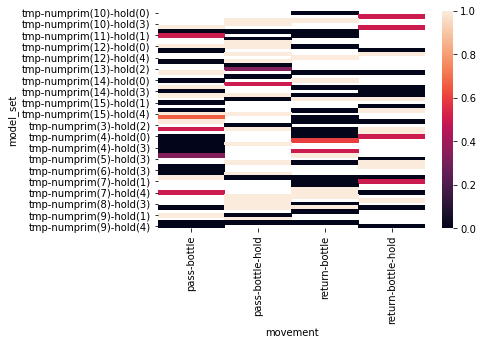

In [354]:
sns.heatmap(model)